# Задание 1
## Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

In [1]:
# Импортируем необходимые библиотеки
import datetime as dt
import seaborn as sns
import pandas as pd
pd.set_option('display.max_rows', 24)
pd.set_option('display.max_columns', 180)
pd.set_option('display.width', 1000)

%matplotlib inline

In [2]:
sns.set(
    font_scale=2,
    style="darkgrid",
    rc={'figure.figsize': (20, 7)})

# Предобработка данных

In [3]:
# Считываем данные

reg_path = '~/shared/problem1-reg_data.csv'
auth_path = '~/shared/problem1-auth_data.csv'

reg_data = pd.read_csv(reg_path, sep=';')
auth_data = pd.read_csv(auth_path, sep=';')

In [4]:
# Мерджим данные в один датафрейм

all_data = auth_data.merge(reg_data, on='uid', how='left') \
                    .sort_values(by='uid', ascending=True) \
                    .reindex(columns=['uid', 'auth_ts', 'reg_ts']) \
                    .reset_index(drop=True)

In [5]:
# Переводим Timestamp в Datetime и
# Cоздаём колонку, показывающую разницу в днях между регистрацией и входом в приложение

all_data['auth_ts'] = all_data['auth_ts'].apply(lambda x: dt.date.fromtimestamp(x))
all_data['reg_ts'] = all_data['reg_ts'].apply(lambda x: dt.date.fromtimestamp(x))
all_data['days_after_reg'] = (all_data['auth_ts'] - all_data['reg_ts']).dt.days

all_data = all_data.rename(columns={'auth_ts': 'auth_date', 'reg_ts': 'reg_date'})

all_data['auth_date'] = pd.to_datetime(all_data['auth_date'])
all_data['reg_date'] = pd.to_datetime(all_data['reg_date'])

# Посмотрим на активность пользователей:
## 1) Среднее время между двумя сессиями
## 2) Наибольшая разница во времени между двумя сессиями 

In [6]:
active_data = all_data[all_data['days_after_reg'] > 0]

In [7]:
first_auth_data = active_data.groupby('uid', as_index=False) \
                             .agg({'days_after_reg': 'min'}) \
                             .rename(columns={'days_after_reg': 'first_auth'})

last_auth_data = active_data.groupby('uid', as_index=False) \
                            .agg({'days_after_reg': 'max'}) \
                            .rename(columns={'days_after_reg': 'last_auth'})

count_auth_data = active_data.groupby('uid', as_index=False) \
                             .agg({'days_after_reg': 'count'}) \
                             .rename(columns={'days_after_reg': 'count_auth'})

In [8]:
users_data = first_auth_data.merge(last_auth_data, on='uid').merge(count_auth_data, on='uid')

In [9]:
users_data['mean_between_auth'] = (users_data['last_auth'] - users_data['first_auth']) / (users_data['count_auth'] - 1)

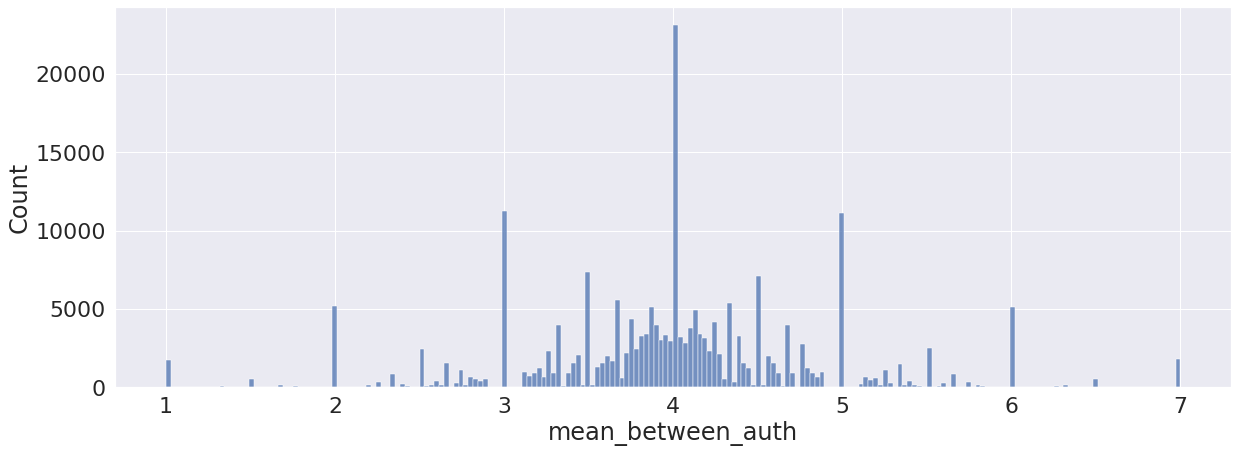

In [10]:
# Как распредлелено среднее время между сессиями у всех пользователей
sns.histplot(data=users_data, x="mean_between_auth");

In [11]:
# Не могу не заметить, что данные сгенирированные (слишком нормальное и симметричное распределение)
# Для всех, не ушедших сразу после регистрации, пользователей среднее время между двумя сессиями не превышает 7 дней.
# 78% всех пользователей не возвращались в приложнеие после регистрации
users_data['mean_between_auth'].describe()

count    217976.000000
mean          3.997274
std           0.890309
min           1.000000
25%           3.559831
50%           4.000000
75%           4.428571
max           7.000000
Name: mean_between_auth, dtype: float64

In [12]:
users_data['first_auth'].describe()

count    238378.000000
mean          3.989605
std           1.781153
min           1.000000
25%           2.000000
50%           4.000000
75%           5.000000
max           7.000000
Name: first_auth, dtype: float64

In [13]:
# Наибольшая разница во времени между двумя сессиями для всех юзеров = 8 дней.
# Если пользователь не заходил в приложение в течение 8 дней, можно считать его ушедшим 
max_days_range = all_data[all_data['days_after_reg'] > 0].sort_values(by=['uid', 'days_after_reg'])
max_days_range['range'] = max_days_range['days_after_reg'] - max_days_range['days_after_reg'].shift(1)
max_days_range['range'].max()

7.0

# Так как само приложение, судя по всему, не подразумевает ежедневное использование (в среднем, пользоавтели заходят в приложение раз в 4 дня), а пользователи, не заходившие в приложение в течение 8 дней, больше вообще в него не заходят:
## Для подсчёта Retention Rate в данном случае лучше всего подойдёт график Rolling Retention (для обобщённой статистики) и Когортный Анализ, считающий пользователя активным, если он заходил в приложение в течение восьми дней после последней сессии

In [14]:
# Создаём копию датасета, оставив только пользователей,
# зарегистрировавшихся в интересующий нас период (min_date - max_date)

min_date = '2016-09-01'  # 'y-m-d'  Период в который регистрировались новые пользователи,
max_date = '2020-09-01'  # 'y-m-d'  чей Retention мы будем считать

max_date = dt.datetime.strptime(max_date, '%Y-%m-%d').date()
min_date = dt.datetime.strptime(min_date, '%Y-%m-%d').date()

data = all_data[all_data['reg_date'] >= pd.to_datetime(min_date)]
data = data[data['reg_date'] <= pd.to_datetime(max_date)]
data = data[data['days_after_reg'] > 0]

In [15]:
# Создаем функцию, которая получает на вход предобработынные данные
# И переменную с количеством дней, на которое мы будем смотреть Rolling Retention

def RollingRetention(data, n_days):
    last_date = all_data['auth_date'].max()
    
    active_days_by_user = data.groupby('uid', as_index=False) \
                              .agg({'days_after_reg': 'max'}) \
                              .rename(columns={'days_after_reg': 'active_days'}) \
                              .reset_index(drop=True)
    
    retention = pd.DataFrame({'day': [x for x in range(1, n_days + 1)]})
    retention['rolling_active'] = 0
    retention['users'] = 0
    
    active_days_by_user = active_days_by_user.merge(all_data[['uid', 'reg_date']].drop_duplicates(), on='uid')
    active_days_by_user['days_after_reg'] = (last_date - active_days_by_user['reg_date']).dt.days
    
    for i in range(retention.shape[0]):
        retention['rolling_active'][i] = active_days_by_user[active_days_by_user['active_days'] > i]['uid'].count()
    for i in range(retention.shape[0]):
        retention['users'][i] = active_days_by_user[active_days_by_user['days_after_reg'] > i]['uid'].count()
    
    retention['rolling_retention'] = (retention['rolling_active'] / retention['users'] * 100).round(2)
    
    lineplot_retention = sns.lineplot(data=retention,
                                      x="day",
                                      y="rolling_retention")
    lineplot_retention.axes \
                      .set_title('Rolling Retention')
    lineplot_retention.set_ylabel("Retention (%)", fontsize=25)
    lineplot_retention.set_xlabel("Day", fontsize=25)
    
    return lineplot_retention

# Возвращаем график Rolling Retention

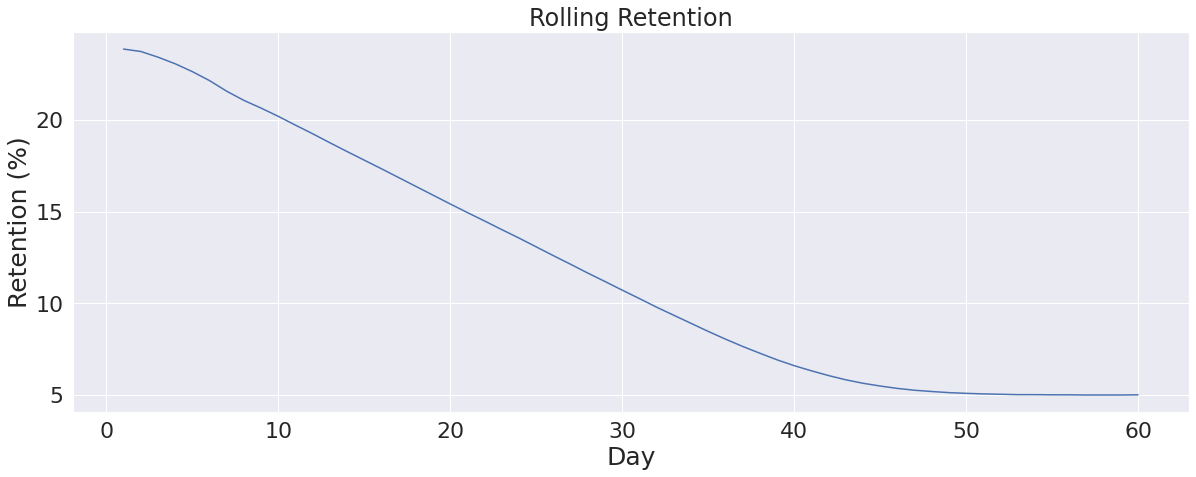

In [16]:
n_days = 60  # int - На какое количество дней будем смотреть Rolling Retention
rolling_retention = RollingRetention(all_data, n_days)

# Лучше всего смотреть на Retention в течение первых 50 дней, так как после этого показатель выходит на плато в 5% после чего снижается крайне медленно, из чего можно сделать вывод, что 5% всех новых пользователей, остаются в приложении на очень долгий период

In [17]:
# Создаем функцию, которая получает на вход предобработынные данные
# И переменную с величиной когорт для когортного анализа Rolling Retention'а

def CohortRollingRetention(data, cohort_period):
    
    all_data['reg_cohort'] = all_data['reg_date'].dt.to_period(cohort_period).dt.to_timestamp()
    data['reg_cohort'] = data['reg_date'].dt.to_period(cohort_period).dt.to_timestamp()
    
    data = data.reset_index(drop=True)
    data['days'] = 0
    for i in range(data.shape[0]):
        if data['days_after_reg'].loc[i] < 9:
            data['days'].loc[i] = 1
            continue
        if data['days_after_reg'].loc[i] < 17:
            data['days'].loc[i] = 9
            continue
        if data['days_after_reg'].loc[i] < 25:
            data['days'].loc[i] = 17
            continue
        if data['days_after_reg'].loc[i] < 33:
            data['days'].loc[i] = 25
            continue
        if data['days_after_reg'].loc[i] < 41:
            data['days'].loc[i] = 33
            continue
        if data['days_after_reg'].loc[i] < 49:
            data['days'].loc[i] = 41
            continue
        if data['days_after_reg'].loc[i] < 57:
            data['days'].loc[i] = 49
        
    cohort_data = data.groupby(['reg_cohort', 'uid', 'days'], as_index=False) \
                      .agg({'days_after_reg': 'count'}) \
                      .groupby(['reg_cohort', 'days'], as_index=False).agg({'days_after_reg': 'count'}) \
                      .query('days > 0') \
                      .rename(columns={'days_after_reg': 'active_users'})
    
    cohort_data['days'] = cohort_data['days'] + 7
    
    total_cohort_users = all_data.groupby('reg_cohort', as_index=False) \
                                 .agg({'uid': 'nunique'}) \
                                 .query('reg_cohort >= "2019-09-01" and reg_cohort <= "2020-09-01"') \
                                 .reset_index(drop=True) \
                                 .rename(columns={'uid': 'users'})
    
    cohort_data = cohort_data.merge(total_cohort_users, on='reg_cohort', how='left')
    cohort_data['rolling_ret'] = round(cohort_data['active_users'] / cohort_data['users'] * 100, 2)
    cohort_data['reg_cohort'] = cohort_data['reg_cohort'].astype(str)
    
    cohort_table = pd.pivot_table(data=cohort_data,
                                  index='reg_cohort', 
                                  columns='days',
                                  values='rolling_ret') \
                     .sort_values(by='reg_cohort', ascending=True)
    return cohort_table

In [18]:
cohort_period = 'M'  # 'Y' (year), 'M' (month), 'W' (week), 'D' (day) - Период в который пользователь зарегестрировался
cohort_rolling_retention = CohortRollingRetention(data, cohort_period)

/opt/tljh/user/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [19]:
cohort_rolling_retention

days,8,16,24,32,40,48,56
reg_cohort,,,,,,,
2019-09-01,23.95,20.49,16.86,13.13,9.47,6.47,5.27
2019-10-01,23.80,20.62,16.95,13.10,9.38,6.43,5.19
2019-11-01,23.96,20.54,17.06,13.31,9.27,6.15,5.01
2019-12-01,24.03,20.88,17.06,13.25,9.53,6.41,5.25
2020-01-01,23.69,20.44,16.57,12.72,9.25,6.29,5.15
2020-02-01,23.52,20.26,16.49,12.87,9.20,6.21,5.04
2020-03-01,23.84,20.70,16.80,13.05,9.36,6.38,5.24
2020-04-01,24.38,21.02,17.10,13.22,9.48,6.41,5.23
2020-05-01,24.05,20.72,17.11,13.38,9.60,6.55,5.31


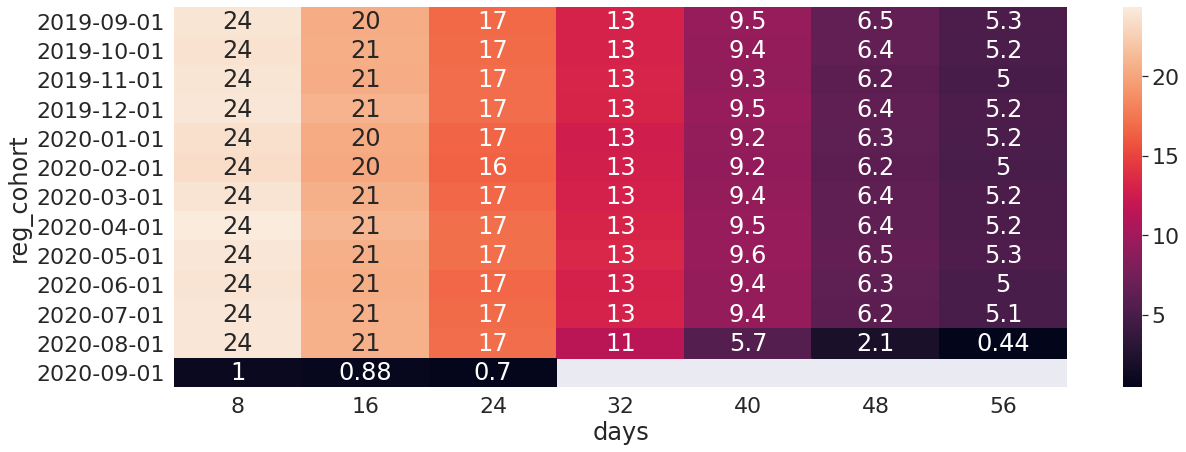

In [20]:
sns.heatmap(cohort_rolling_retention, annot=True)

# Как видно из приведенной Heatmap-таблицы, показатель Retention не имеет месячной сезонности (процент активных пользователей от месяца к месяцу практически не меняется)